# Building an AI-Powered Image Extraction and Description System

Enterprise documents are rich with both textual and visual information—technical diagrams, product photos, charts, illustrations, and descriptive text—but this valuable content remains largely inaccessible. When you need to find "all performance charts" or "product architecture diagrams," you're stuck manually scrolling through hundreds of pages.

## The Challenge

Traditional document processing focuses on basic text extraction, leaving visual elements as unstructured, unsearchable data. Both textual content and visual elements stay trapped in documents, making comprehensive insights hidden and decision-making lack full context.

## The Solution

Unstructured's AI-powered platform transforms how organizations extract and understand both textual and visual content at scale. Unlike basic extraction tools, it provides intelligent hi-resolution processing, AI-generated descriptions that make images searchable, comprehensive text extraction, and seamless integration with your existing infrastructure.

## What We'll Build

In this tutorial, we'll create an intelligent document processing system that extracts both text and images from PDF documents in S3, generates AI-powered descriptions for visual content, and creates a searchable knowledge base.

```
┌─────────────────┐                           ┌─────────────────────────┐
│   S3 PDFs       │──── IMAGE WORKFLOW ──────▶│                         │
│ (Product Docs)  │                           │    Unstructured API     │
└─────────────────┘                           │                         │
                                              │  Hi-Res Partition →     │
                                              │  AI Image Description → │
                                              │  Vector Embeddings      │
                                              │                         │
                                              └────────────┬────────────┘
                                                           │
                                              ┌────────────▼────────────┐
                                              │    image-pipeline       │
                                              │   (Visual Knowledge)    │
                                              └─────────────────────────┘
```

By the end, you'll have a working system that can intelligently find and describe both textual and visual content, answer questions about diagrams and charts, and provide comprehensive insights about your document assets.

## Getting Started: Your Unstructured API Key

You'll need an Unstructured API key to access the AI-powered image processing platform.

### Sign Up and Get Your API Key

Visit https://platform.unstructured.io to sign up for a free account, navigate to API Keys in the sidebar, and generate your API key. For Team or Enterprise accounts, select the correct organizational workspace before creating your key.

**Need help?** Contact Unstructured Support at support@unstructured.io

## Configuration: Setting Up Your Environment

We'll configure your environment with the necessary API keys and credentials to connect to data sources and AI services.

### Creating a .env File in Google Colab

For better security and organization, we'll create a `.env` file directly in your Colab environment. Run the code cell below to create the file with placeholder values, then edit it with your actual credentials.

After running the code cell, you'll need to replace each placeholder value (like `your-unstructured-api-key`) with your actual API keys and credentials.

In [13]:
import os

def create_dotenv_file():
    """Create a .env file with placeholder values for the user to fill in, only if it doesn't already exist."""
    
    # Check if .env file already exists
    if os.path.exists('.env'):
        print("📝 .env file already exists - skipping creation")
        print("💡 Using existing .env file with current configuration")
        return
    
    env_content = """# Image Processing Pipeline Environment Configuration
# Fill in your actual values below
# Configuration - Set these explicitly

# ===================================================================
# AWS CONFIGURATION
# ===================================================================
AWS_ACCESS_KEY_ID="your-aws-access-key-id"
AWS_SECRET_ACCESS_KEY="your-aws-secret-access-key"
AWS_REGION="us-east-1"

# ===================================================================
# UNSTRUCTURED API CONFIGURATION  
# ===================================================================
UNSTRUCTURED_API_KEY="your-unstructured-api-key"
UNSTRUCTURED_API_URL="https://platform.unstructuredapp.io/api/v1"

# ===================================================================
# ELASTICSEARCH CONFIGURATION
# ===================================================================
ELASTICSEARCH_HOST="https://your-cluster.es.io:443"
ELASTICSEARCH_API_KEY="your-elasticsearch-api-key"

# ===================================================================
# PIPELINE DATA SOURCES
# ===================================================================
S3_SOURCE_BUCKET="example-data-bose-headphones"
ELASTICSEARCH_INDEX="image-pipeline"

# ===================================================================
# OPENAI API CONFIGURATION 
# ===================================================================
OPENAI_API_KEY="your-openai-api-key"
"""
    
    with open('.env', 'w') as f:
        f.write(env_content)
    
    print("✅ Created .env file with placeholder values")
    print("📝 Please edit the .env file and replace the placeholder values with your actual credentials")
    print("🔒 The .env file will be loaded automatically by the pipeline")

# Create the .env file only if it doesn't exist
create_dotenv_file()

📝 .env file already exists - skipping creation
💡 Using existing .env file with current configuration


### Installing Required Dependencies

Installing the Python packages needed: Unstructured client, Elasticsearch connector, AWS SDK, OpenAI integration, and image processing dependencies.

In [14]:
import sys, subprocess

def ensure_notebook_deps() -> None:
    packages = [
        "jupytext",
        "python-dotenv", 
        "unstructured-client",
        "elasticsearch",
        "boto3",
        "PyYAML",
        "langchain",
        "langchain-elasticsearch",
        "langchain-openai"
    ]
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", *packages])
    except Exception:
        # If install fails, continue; imports below will surface actionable errors
        pass

# Install notebook dependencies (safe no-op if present)
ensure_notebook_deps()

import os
import time
import json
import zipfile
import tempfile
import requests
from pathlib import Path
from dotenv import load_dotenv
from urllib.parse import urlparse

import boto3
from botocore.exceptions import ClientError, NoCredentialsError
from elasticsearch import Elasticsearch
from elasticsearch.helpers import bulk

from unstructured_client import UnstructuredClient
from unstructured_client.models.operations import (
    CreateSourceRequest,
    CreateDestinationRequest,
    CreateWorkflowRequest
)
from unstructured_client.models.shared import (
    CreateSourceConnector,
    CreateDestinationConnector,
    WorkflowNode,
    WorkflowType,
    CreateWorkflow
)

# =============================================================================
# ENVIRONMENT CONFIGURATION
# =============================================================================
# Load from .env file if it exists
load_dotenv()

# Configuration constants
SKIPPED = "SKIPPED"
UNSTRUCTURED_API_URL = os.getenv("UNSTRUCTURED_API_URL", "https://platform.unstructuredapp.io/api/v1")

# Get environment variables
UNSTRUCTURED_API_KEY = os.getenv("UNSTRUCTURED_API_KEY")
AWS_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")
AWS_REGION = os.getenv("AWS_REGION", "us-east-1")
S3_SOURCE_BUCKET = os.getenv("S3_SOURCE_BUCKET")
S3_DESTINATION_BUCKET = os.getenv("S3_DESTINATION_BUCKET")
S3_OUTPUT_PREFIX = os.getenv("S3_OUTPUT_PREFIX", "")
ELASTICSEARCH_HOST = os.getenv("ELASTICSEARCH_HOST")
ELASTICSEARCH_API_KEY = os.getenv("ELASTICSEARCH_API_KEY")
ELASTICSEARCH_INDEX = os.getenv("ELASTICSEARCH_INDEX", "sales-records-consolidated")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

# Validation
REQUIRED_VARS = {
    "UNSTRUCTURED_API_KEY": UNSTRUCTURED_API_KEY,
    "AWS_ACCESS_KEY_ID": AWS_ACCESS_KEY_ID,
    "AWS_SECRET_ACCESS_KEY": AWS_SECRET_ACCESS_KEY,
    "ELASTICSEARCH_HOST": ELASTICSEARCH_HOST,
    "ELASTICSEARCH_API_KEY": ELASTICSEARCH_API_KEY,
    "S3_SOURCE_BUCKET": S3_SOURCE_BUCKET,
}

missing_vars = [key for key, value in REQUIRED_VARS.items() if not value]
if missing_vars:
    print(f"❌ Missing required environment variables: {', '.join(missing_vars)}")
    print("Please set these environment variables or create a .env file with your credentials.")
    raise ValueError(f"Missing required environment variables: {missing_vars}")

print("✅ Configuration loaded successfully")

✅ Configuration loaded successfully



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


## AWS S3: Your Document Repository

Now that we have our environment configured, let's set up the data source for our image extraction system. Your PDF documents need to be accessible via S3, where your product manuals, technical documentation, and other visual-rich content lives, waiting to be processed into searchable visual knowledge.

### What You Need

**An existing S3 bucket** containing the PDF documents you want to process for image extraction. For this tutorial, we'll use sample product manuals with rich visual content, but in production, this would be your actual business documents.

> **Note**: This tutorial assumes you have an existing S3 bucket with PDF documents containing images. For detailed S3 setup instructions, see the [Unstructured S3 source connector documentation](https://docs.unstructured.io/api-reference/api-services/source-connectors/s3).

You'll need an AWS account with S3 access, an IAM user with S3 read permissions for your bucket, and access keys (Access Key ID and Secret Access Key).

### Example Document Content

The following image shows what a document being processed might look like. This demonstrates the type of visual-rich content that will be processed, with images extracted and AI-generated descriptions created for searchable visual knowledge.

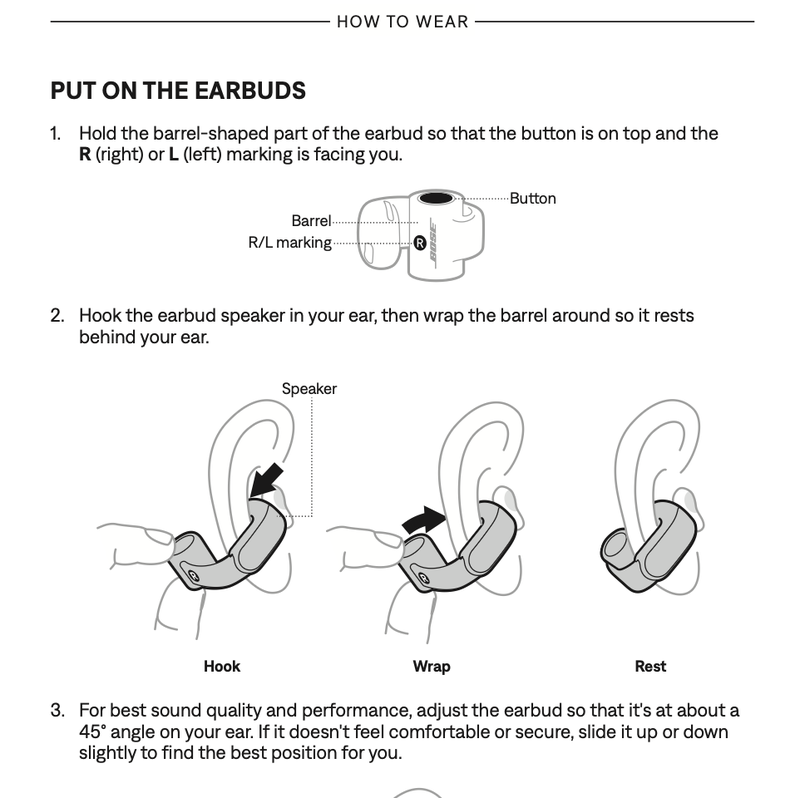

## S3 Source Connector

Creating the connection to your S3 document repository. This connector will authenticate with your bucket, discover PDF files, and stream them to the processing pipeline.

In [15]:
def create_s3_source_connector():
    """Create an S3 source connector for PDF documents."""
    try:
        if not S3_SOURCE_BUCKET:
            raise ValueError("S3_SOURCE_BUCKET is required (bucket name, s3:// URL, or https:// URL)")
        value = S3_SOURCE_BUCKET.strip()

        if value.startswith("s3://"):
            s3_style = value if value.endswith("/") else value + "/"
        elif value.startswith("http://") or value.startswith("https://"):
            parsed = urlparse(value)
            host = parsed.netloc
            path = parsed.path or "/"
            bucket = host.split(".s3.")[0]
            s3_style = f"s3://{bucket}{path if path.endswith('/') else path + '/'}"
        else:
            s3_style = f"s3://{value if value.endswith('/') else value + '/'}"
        
        with UnstructuredClient(api_key_auth=UNSTRUCTURED_API_KEY) as client:
            response = client.sources.create_source(
                request=CreateSourceRequest(
                    create_source_connector=CreateSourceConnector(
                        name="<name>",
                        type="s3",
                        config={
                            "remote_url": s3_style,
                            "recursive": True, 
                            "key": AWS_ACCESS_KEY_ID,
                            "secret": AWS_SECRET_ACCESS_KEY,
                        }
                    )
                )
            )
        
        source_id = response.source_connector_information.id
        print(f"✅ Created S3 PDF source connector: {source_id} -> {s3_style}")
        return source_id
        
    except Exception as e:
        print(f"❌ Error creating S3 source connector: {e}")
        return None

# Create S3 source connector
source_id = create_s3_source_connector()

if source_id:
    print(f"📁 S3 source connector ready to read PDF documents from: {S3_SOURCE_BUCKET}")
else:
    print("❌ Failed to create S3 source connector - check your credentials and bucket configuration") 

/Users/nvannest/Documents/GitHub/rag-image-extraction-and-description/venv/lib/python3.13/site-packages/pydantic/functional_validators.py:218: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `enum` - serialized value may not be as expected [input_value='s3', input_type=str])
  function=lambda v, h: h(v),
/Users/nvannest/Documents/GitHub/rag-image-extraction-and-description/venv/lib/python3.13/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `enum` - serialized value may not be as expected [input_value='s3', input_type=str])
  return self.__pydantic_serializer__.to_python(
INFO: HTTP Request: POST https://platform.unstructuredapp.io/api/v1/sources/ "HTTP/1.1 200 OK"


✅ Created S3 PDF source connector: 6601537b-ff26-4de0-8750-ce4009c08db8 -> s3://example-data-bose-headphones/
📁 S3 source connector ready to read PDF documents from: example-data-bose-headphones


## Elasticsearch: Your Visual Knowledge Hub

Elasticsearch serves as the destination where our processed visual content will be stored. Unlike traditional document storage, this will be a specialized index optimized for image metadata, AI-generated descriptions, and vector-based similarity search of visual content.

### What You Need

**Elasticsearch cluster** with API key authentication from Elastic Cloud (managed service). This gives you the reliability and scalability needed for enterprise image processing applications.

### API Key Permissions

Your Elasticsearch API key needs these permissions:

```json
{
  "image-pipeline-access": {
    "cluster": [
      "monitor"
    ],
    "indices": [
      {
        "names": [
          "image-pipeline"
        ],
        "privileges": [
          "create_index",
          "delete_index",
          "manage",
          "write",
          "read",
          "view_index_metadata",
          "monitor"
        ],
        "allow_restricted_indices": false
      }
    ],
    "applications": [],
    "run_as": [],
    "metadata": {},
    "transient_metadata": {
      "enabled": true
    }
  }
}
```

The pipeline uses the `image-pipeline` index as the destination for your visual knowledge base, containing extracted images, AI descriptions, and searchable metadata. The index is created automatically by the pipeline with optimized mappings for image processing workflows.

### Why Image-Optimized Storage Matters

Traditional document storage treats images as binary attachments. For AI-powered image processing, we store base64-encoded image data alongside AI-generated descriptions, metadata, and vector embeddings. This approach ensures that when someone searches for "performance charts" or "architecture diagrams," they get both the visual content and contextual understanding in one result.

The destination index structure is structured for RAG applications:
```json
{
  "element_id": "keyword",      // Unique element identifier
  "type": "keyword",            // Document type (e.g., "Image")
  "text": "text",              // AI-generated image descriptions
  "metadata": {
    "filename": "keyword",      // Source document filename
    "page_number": "integer",   // Page number from PDF
    "image_base64": "text",     // Base64-encoded image data
    "image_mime_type": "keyword", // Image format (jpeg, png, etc.)
    "filetype": "keyword",      // Source file type
    "languages": "keyword"      // Detected languages
  },
  "embeddings": "dense_vector"  // Vector embeddings for similarity search
}
```

Example transformation:
```
Before: [Binary image data, no searchable content]

After: {
  "element_id": "uuid_001",
  "type": "Image",
  "text": "A bar chart showing quarterly performance metrics with revenue increasing 23% year-over-year",
  "metadata": {
    "filename": "Q4-report.pdf",
    "page_number": 15,
    "image_base64": "[base64 encoded image data]",
    "image_mime_type": "image/png",
    "filetype": "pdf"
  },
  "embeddings": [1536-dimensional vector for similarity search]
}
```

**Fresh index on every run**: The pipeline recreates the `image-pipeline` index each time to ensure clean, consistent results for your image processing workflows.

### Example Output Data Structure

After processing, the pipeline creates an `image-pipeline` index containing extracted images and their AI-generated descriptions. The image below shows an example of what the processed data structure might look like, including both the base64-encoded images and their corresponding detailed text descriptions generated by the AI image enrichment workflow.

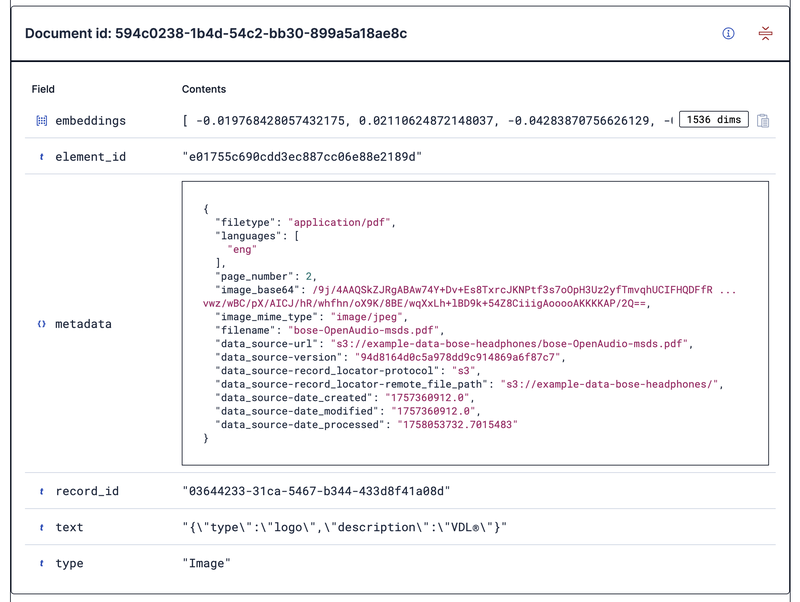

## Index Preparation

Recreating the `image-pipeline` index with optimized mappings for the processing workflow.

In [16]:
def run_elasticsearch_preprocessing():
    """Check and manage Elasticsearch indices for the image processing pipeline."""
    print("🔧 Running Elasticsearch preprocessing...")
    
    try:
        es = Elasticsearch(
            ELASTICSEARCH_HOST,
            api_key=ELASTICSEARCH_API_KEY,
            request_timeout=60,
            max_retries=3,
            retry_on_timeout=True
        )
        
        image_index = "image-pipeline"
        print(f"🔍 Checking {image_index} index...")
        
        if es.indices.exists(index=image_index):
            print(f"🗑️ Deleting existing {image_index} index for fresh run...")
            es.indices.delete(index=image_index)
        
        print(f"🔧 Creating fresh {image_index} index...")
        mapping = {
            "settings": {
                "number_of_shards": 1,
                "number_of_replicas": 1
            },
            "mappings": {
                "properties": {
                    "element_id": {"type": "keyword"},
                    "type": {"type": "keyword"},
                    "text": {"type": "text", "analyzer": "standard"},
                    "metadata": {
                        "type": "object",
                        "properties": {
                            "filename": {"type": "keyword"},
                            "page_number": {"type": "integer"},
                            "image_base64": {"type": "text", "index": False},
                            "image_mime_type": {"type": "keyword"},
                            "filetype": {"type": "keyword"},
                            "languages": {"type": "keyword"}
                        }
                    },
                    "embeddings": {"type": "dense_vector", "dims": 1536}
                }
            }
        }
        
        es.indices.create(index=image_index, body=mapping)
        es.indices.refresh(index=image_index)
        
        print(f"✅ Successfully created fresh {image_index} index")
        print("✅ Elasticsearch preprocessing completed successfully")
        return True
        
    except Exception as e:
        print(f"❌ Error during Elasticsearch preprocessing: {e}")
        return False

## Elasticsearch Destination Connector

Creating the destination where processed images and AI-generated descriptions will be stored. The `image-pipeline` index will be recreated fresh for clean results.

In [17]:
def create_elasticsearch_destination_connector():
    """Create an Elasticsearch destination connector for processed results."""
    try:
        with UnstructuredClient(api_key_auth=UNSTRUCTURED_API_KEY) as client:
            response = client.destinations.create_destination(
                request=CreateDestinationRequest(
                    create_destination_connector=CreateDestinationConnector(
                        name=f"elasticsearch_image_pipeline_destination_{int(time.time())}",
                        type="elasticsearch",
                        config={
                            "hosts": [ELASTICSEARCH_HOST],
                            "es_api_key": ELASTICSEARCH_API_KEY,
                            "index_name": "image-pipeline"
                        }
                    )
                )
            )

        destination_id = response.destination_connector_information.id
        print(f"✅ Created Elasticsearch destination connector: {destination_id}")
        return destination_id
        
    except Exception as e:
        print(f"❌ Error creating Elasticsearch destination connector: {e}")
        return None

# Create Elasticsearch destination connector
destination_id = create_elasticsearch_destination_connector()

if destination_id:
    print(f"🔍 Elasticsearch destination connector ready to store processed images and descriptions")
    print(f"📊 Index: image-pipeline at {ELASTICSEARCH_HOST}")
else:
    print("❌ Failed to create Elasticsearch destination connector - check your credentials and host configuration") 

/Users/nvannest/Documents/GitHub/rag-image-extraction-and-description/venv/lib/python3.13/site-packages/pydantic/functional_validators.py:218: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `enum` - serialized value may not be as expected [input_value='elasticsearch', input_type=str])
  function=lambda v, h: h(v),
/Users/nvannest/Documents/GitHub/rag-image-extraction-and-description/venv/lib/python3.13/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `enum` - serialized value may not be as expected [input_value='elasticsearch', input_type=str])
  return self.__pydantic_serializer__.to_python(
INFO: HTTP Request: POST https://platform.unstructuredapp.io/api/v1/destinations/ "HTTP/1.1 200 OK"


✅ Created Elasticsearch destination connector: 87d8fa3d-5c7f-4e8c-9e5b-f619eb348ab6
🔍 Elasticsearch destination connector ready to store processed images and descriptions
📊 Index: image-pipeline at https://2371b9a1d2ad40c590fd1e22652a8236.us-central1.gcp.cloud.es.io:443


## Image Processing Pipeline

Configuring the four-stage pipeline: Hi-Res Partitioner → AI Image Description → Chunker (with orig_elements) → Vector Embeddings.

The chunker node uses `include_orig_elements: True` to preserve original image elements within composite documents, allowing access to both the combined text and individual image components.

## Creating Your Image Processing Workflow

Assembling the image extraction pipeline to connect S3 documents to the processing workflow.

In [18]:
def create_image_workflow_nodes():
    """Create workflow nodes for image processing pipeline."""
    partitioner_workflow_node = WorkflowNode(
        name="Partitioner",
        subtype="unstructured_api",
        type="partition",
        settings={
            "strategy": "hi_res",
            "exclude_elements": [
                "Address",
                "PageBreak",
                "Formula",
                "EmailAddress",
                "PageNumber"
            ],
            "extract_image_block_types": [
                "image",
            ],
        }
    )

    image_description_enrichment_workflow_node = WorkflowNode(
        name="Enrichment",
        subtype="openai_image_description",
        type="prompter",
        settings={}
    )

    chunker_node = WorkflowNode(
        name="Chunker",
        subtype="chunk_by_character",
        type="chunk",
        settings={
            "include_orig_elements": True,
            "max_characters": 1500,
            "new_after_n_chars": 1200,
            "overlap": 100
        }
    )

    embedder_node = WorkflowNode(
        name="Embedder_Node",
        subtype="openai",
        type="embed",
        settings={
            "model_name": "text-embedding-3-small"
        }
    )

    return partitioner_workflow_node, image_description_enrichment_workflow_node, chunker_node, embedder_node

def create_single_workflow(s3_source_id, destination_id):
    """Create a single workflow for S3 image processing."""
    try:
        partitioner_node, image_enrichment_node, chunker_node, embedder_node = create_image_workflow_nodes()

        with UnstructuredClient(api_key_auth=UNSTRUCTURED_API_KEY) as client:
            s3_workflow = CreateWorkflow(
                name=f"S3-Image-Processing-Workflow_{int(time.time())}",
                source_id=s3_source_id,
                destination_id=destination_id,
                workflow_type=WorkflowType.CUSTOM,
                workflow_nodes=[
                    partitioner_node,
                    image_enrichment_node,
                    chunker_node,
                    embedder_node
                ]
            )

            s3_response = client.workflows.create_workflow(
                request=CreateWorkflowRequest(
                    create_workflow=s3_workflow
                )
            )

        s3_workflow_id = s3_response.workflow_information.id
        print(f"✅ Created S3 image processing workflow: {s3_workflow_id}")

        return s3_workflow_id

    except Exception as e:
        print(f"❌ Error creating image processing workflow: {e}")
        return None

## Starting Your Image Processing Job

With our workflow configured, it's time to put it into action. This step submits the image processing workflow to the Unstructured API and returns a job ID for monitoring the extraction and description process.

In [19]:
def run_workflow(workflow_id, workflow_name):
    """Run a workflow and return job information."""
    try:
        with UnstructuredClient(api_key_auth=UNSTRUCTURED_API_KEY) as client:
            response = client.workflows.run_workflow(
                request={"workflow_id": workflow_id}
            )
        
        job_id = response.job_information.id
        print(f"✅ Started {workflow_name} job: {job_id}")
        return job_id
        
    except Exception as e:
        print(f"❌ Error running {workflow_name} workflow: {e}")
        return None

def poll_job_status(job_id, job_name, wait_time=30):
    """Poll job status until completion."""
    print(f"⏳ Monitoring {job_name} job status...")
    
    while True:
        try:
            with UnstructuredClient(api_key_auth=UNSTRUCTURED_API_KEY) as client:
                response = client.jobs.get_job(
                    request={"job_id": job_id}
                )
            
            job = response.job_information
            status = job.status
            
            if status in ["SCHEDULED", "IN_PROGRESS"]:
                print(f"⏳ {job_name} job status: {status}")
                time.sleep(wait_time)
            elif status == "COMPLETED":
                print(f"✅ {job_name} job completed successfully!")
                return job
            elif status == "FAILED":
                print(f"❌ {job_name} job failed!")
                return job
            else:
                print(f"❓ Unknown {job_name} job status: {status}")
                return job
                
        except Exception as e:
            print(f"❌ Error polling {job_name} job status: {e}")
            time.sleep(wait_time)

## Monitoring Your Image Processing Progress

Jobs progress through scheduled, in-progress, completed, or failed states. The `poll_job_status` function checks status every 30 seconds and blocks execution until processing completes, so you can see exactly what's happening with your image extraction and AI description generation.

## Pipeline Execution Summary

The following summary displays all resources created during image processing pipeline setup: S3 data source path, connector IDs, workflow ID, job ID, and processing status.

In [20]:
import os

def print_pipeline_summary(workflow_id, job_id):
    """Print pipeline summary for image processing workflow."""
    print("\n" + "=" * 80)
    print("📊 IMAGE PROCESSING PIPELINE SUMMARY")
    print("=" * 80)
    print(f"📁 S3 Source (PDFs): {S3_SOURCE_BUCKET}")
    print(f"📤 Elasticsearch Destination: {ELASTICSEARCH_HOST}/image-pipeline")
    print(f"")
    print(f"⚙️ Image Processing Workflow ID: {workflow_id}")
    print(f"🚀 Image Processing Job ID: {job_id}")
    print()
    print("💡 Monitor job progress at: https://platform.unstructured.io")
    print("=" * 80)

def verify_customer_support_results(job_id=None):
    """
    Pull 5 random records of type "Image" from the image-pipeline index and prettyprint them.
    Display the extracted base64 images and their AI-generated text descriptions.

    Args:
        job_id (str, optional): If provided, will poll job status until completion before verification.
                               If None, assumes job has completed and goes directly to verification.
    """
    import pprint
    import base64
    from IPython.display import Image, display
    from io import BytesIO

    if job_id is not None and job_id != "" and isinstance(job_id, str):
        print("🔍 Starting verification process...")
        print("⏳ Polling job status until completion...")

        job_info = poll_job_status(job_id, "Image Processing")

        if not job_info or job_info.status != "COMPLETED":
            print(f"\n❌ Job did not complete successfully. Status: {job_info.status if job_info else 'Unknown'}")
            print("💡 Check the Unstructured dashboard for more details.")
            return

        print("\n🔍 Job completed successfully! Verifying processed results...")
        print("-" * 50)
    else:
        if job_id is not None:
            print(f"⚠️  Invalid job_id provided: {job_id} (type: {type(job_id)})")
        print("🔍 Verifying processed results in 'image-pipeline' index (skipping job polling)...")

    try:
        es = Elasticsearch(
            ELASTICSEARCH_HOST,
            api_key=ELASTICSEARCH_API_KEY,
            request_timeout=60,
            max_retries=3,
            retry_on_timeout=True
        )

        index_name = "image-pipeline"

        if not es.indices.exists(index=index_name):
            print(f"❌ Index '{index_name}' does not exist. Workflow may not have written results yet.")
            return

        count_response = es.count(index=index_name)
        total_docs = count_response['count']
        print(f"📊 Total processed documents: {total_docs}")

        if total_docs == 0:
            print("⏳ No documents found yet. Workflow may still be processing or index is empty.")
            print("💡 Check the Unstructured dashboard for job status.")
            return

        # Get document type statistics
        type_stats_response = es.search(
            index=index_name,
            body={
                "size": 0,
                "aggs": {
                    "document_types": {
                        "terms": {
                            "field": "type",
                            "size": 20
                        }
                    }
                }
            }
        )
        
        print(f"\n📊 Document Type Statistics:")
        print("-" * 40)
        for bucket in type_stats_response['aggregations']['document_types']['buckets']:
            doc_type = bucket['key']
            count = bucket['doc_count']
            print(f"  {doc_type}: {count} documents")
        print("-" * 40)

        # Check for documents with orig_elements (composite elements with images)
        composite_with_images_response = es.count(
            index=index_name,
            body={
                "query": {
                    "bool": {
                        "must": [
                            {"term": {"type": "CompositeElement"}},
                            {"exists": {"field": "metadata.orig_elements"}}
                        ]
                    }
                }
            }
        )
        composite_docs = composite_with_images_response['count']
        print(f"🔗 CompositeElement documents with orig_elements: {composite_docs}")

        print(f"\n📋 Retrieving 5 random CompositeElement records with orig_elements:")
        print("=" * 60)

        # Now search for CompositeElement documents instead of Image documents
        sample_response = es.search(
            index=index_name,
            body={
                "size": 5,
                "_source": True,
                "query": {
                    "function_score": {
                        "query": {
                            "bool": {
                                "must": [
                                    {"term": {"type": "CompositeElement"}},
                                    {"exists": {"field": "metadata.orig_elements"}}
                                ]
                            }
                        },
                        "random_score": {}
                    }
                }
            }
        )

        if not sample_response['hits']['hits']:
            print("❌ No CompositeElement documents with orig_elements found.")
            return

        for i, hit in enumerate(sample_response['hits']['hits'], 1):
            print(f"\n{'='*20} COMPOSITE RECORD {i} {'='*20}")
            record = hit['_source']

            # Look for images in orig_elements
            orig_elements = record.get('metadata', {}).get('orig_elements', [])
            images_found = []
            
            # Handle the case where orig_elements is stored as a JSON string or compressed data
            if isinstance(orig_elements, str):
                try:
                    import json
                    # First try to parse as plain JSON
                    orig_elements = json.loads(orig_elements)
                except json.JSONDecodeError:
                    try:
                        # If that fails, try to decompress first (looks like base64 + compression)
                        import base64
                        import zlib
                        compressed_data = base64.b64decode(orig_elements)
                        decompressed_data = zlib.decompress(compressed_data)
                        orig_elements = json.loads(decompressed_data.decode('utf-8'))
                    except Exception:
                        # If all else fails, skip this document's images
                        orig_elements = []
            
            # Ensure orig_elements is a list
            if not isinstance(orig_elements, list):
                print(f"⚠️  Warning: orig_elements is not a list, it's {type(orig_elements)}")
                orig_elements = []
            
            for element in orig_elements:
                # Ensure element is a dictionary before calling .get()
                if isinstance(element, dict) and element.get('type') == 'Image' and element.get('metadata', {}).get('image_base64'):
                    images_found.append(element)

            # Display images from orig_elements
            if images_found:
                print(f"🖼️  Found {len(images_found)} image(s) in orig_elements:")
                for j, image_element in enumerate(images_found, 1):
                    try:
                        if not isinstance(image_element, dict):
                            print(f"❌ Error: image_element {j} is not a dictionary: {type(image_element)}")
                            continue
                            
                        image_base64 = image_element['metadata']['image_base64']
                        image_data = base64.b64decode(image_base64)
                        filename = image_element.get('metadata', {}).get('filename', 'document')
                        print(f"  Image {j} from {filename}:")
                        display(Image(data=image_data))
                    except Exception as e:
                        print(f"❌ Error displaying image {j}: {e}")
            else:
                print("❌ No images found in orig_elements")

            # Display composite text content
            if 'text' in record and record['text']:
                print(f"\n🤖 Composite text description:")
                print("-" * 40)
                print(record['text'])
                print("-" * 40)
            else:
                print("❌ No composite text description found")

            print(f"\n📋 Document metadata:")
            metadata = record.get('metadata', {})
            print(f"   📄 Filename: {metadata.get('filename', 'N/A')}")
            print(f"   📖 Page: {metadata.get('page_number', 'N/A')}")
            print(f"   🆔 Element ID: {record.get('element_id', 'N/A')}")
            print(f"   📝 Type: {record.get('type', 'N/A')}")
            print(f"   🔗 Orig Elements Count: {len(orig_elements)}")

            print(f"\n📋 Full Record Structure:")
            # Create a copy of the record for printing with cleaned up fields
            print_record = record.copy()

            # Replace embeddings with placeholder
            if 'embeddings' in print_record:
                print_record['embeddings'] = "[...]"

            # Replace base64 image data in orig_elements with placeholder and handle compressed data
            if 'metadata' in print_record and isinstance(print_record['metadata'], dict):
                print_metadata = print_record['metadata'].copy()
                if 'orig_elements' in print_metadata:
                    orig_elements_raw = print_metadata['orig_elements']
                    
                    # Handle the case where orig_elements is stored as a JSON string or compressed data
                    if isinstance(orig_elements_raw, str):
                        try:
                            import json
                            # First try to parse as plain JSON
                            orig_elements_parsed = json.loads(orig_elements_raw)
                        except json.JSONDecodeError:
                            try:
                                # If that fails, try to decompress first (looks like base64 + compression)
                                import base64
                                import zlib
                                compressed_data = base64.b64decode(orig_elements_raw)
                                decompressed_data = zlib.decompress(compressed_data)
                                orig_elements_parsed = json.loads(decompressed_data.decode('utf-8'))
                            except Exception:
                                # If all else fails, replace with summary
                                print_metadata['orig_elements'] = f"[Compressed data - {len(orig_elements_raw)} characters]"
                    else:
                        orig_elements_parsed = orig_elements_raw
                    
                    # Clean the parsed elements
                    if isinstance(orig_elements_parsed, list):
                        cleaned_orig_elements = []
                        for element in orig_elements_parsed[:5]:  # Limit to first 5 elements for readability
                            if isinstance(element, dict):
                                clean_element = element.copy()
                                if 'metadata' in clean_element and 'image_base64' in clean_element['metadata']:
                                    clean_element['metadata'] = clean_element['metadata'].copy()
                                    clean_element['metadata']['image_base64'] = "[base64 image data]"
                                cleaned_orig_elements.append(clean_element)
                            else:
                                cleaned_orig_elements.append(element)
                        
                        # Add summary if there are more elements
                        if len(orig_elements_parsed) > 5:
                            cleaned_orig_elements.append(f"... and {len(orig_elements_parsed) - 5} more elements")
                        
                        print_metadata['orig_elements'] = cleaned_orig_elements
                    else:
                        print_metadata['orig_elements'] = f"[Non-list data: {type(orig_elements_parsed)}]"
                        
                print_record['metadata'] = print_metadata

            # Pretty print with improved formatting to avoid breaking strings into individual characters
            def safe_pprint(obj, depth=6):
                """Custom pretty print that avoids breaking strings into individual characters."""
                import json
                try:
                    # Use JSON formatting for cleaner output
                    formatted = json.dumps(obj, indent=2, default=str)
                    print(formatted)
                except:
                    # Fallback to pprint with limited depth
                    pprint.pprint(obj, depth=3, compact=True, sort_dicts=False)
            
            safe_pprint(print_record)

        print(f"\n" + "=" * 70)
        print("🎉 IMAGE-PIPELINE VERIFICATION COMPLETE")
        print("=" * 70)
        print("✅ Index exists and contains processed documents")
        print(f"✅ Found {composite_docs} CompositeElement documents with orig_elements")
        print("✅ Random CompositeElement sample retrieved successfully")
        print("🖼️  Extracted base64 images displayed from orig_elements where available")
        print("🤖 Composite text descriptions shown")
        print("✅ Ready for image-based RAG queries!")

    except Exception as e:
        print(f"❌ Error verifying results: {e}")
        print("💡 This is normal if workflow is still processing or if there is a connection issue.")



## Orchestrating Your Complete Image Pipeline

The main function coordinates all pipeline steps in logical sequence: environment validation, S3 connector setup, workflow creation, execution, and summary reporting for your image extraction and description system.

In [21]:
# Step 1: Elasticsearch preprocessing
print("🚀 Starting Image Processing Pipeline")
print("\n🔧 Step 1: Elasticsearch preprocessing")
print("-" * 50)

if not run_elasticsearch_preprocessing():
    print("❌ Failed to complete Elasticsearch preprocessing")
else:
    print("\n🔗 Step 2: Creating S3 source connector")
    print("-" * 50)
    
    s3_source_id = create_s3_source_connector()
    if s3_source_id:
        print("\n🎯 Step 3: Creating Elasticsearch destination connector")
        print("-" * 50)
        
        destination_id = create_elasticsearch_destination_connector()
        if destination_id:
            print("\n⚙️ Step 4: Creating image processing workflow")
            print("-" * 50)
            
            workflow_id = create_single_workflow(s3_source_id, destination_id)
            
            if workflow_id:
                print("\n🚀 Step 5: Running workflow")
                print("-" * 50)
                
                job_id = run_workflow(workflow_id, "S3 Image Processing")
                if job_id:
                    print_pipeline_summary(workflow_id, job_id)
                else:
                    print("❌ Failed to start image processing workflow")
            else:
                print("❌ Failed to create image processing workflow")
        else:
            print("❌ Failed to create destination connector")
    else:
        print("❌ Failed to create S3 source connector") 

🚀 Starting Image Processing Pipeline

🔧 Step 1: Elasticsearch preprocessing
--------------------------------------------------
🔧 Running Elasticsearch preprocessing...
🔍 Checking image-pipeline index...


INFO: HEAD https://2371b9a1d2ad40c590fd1e22652a8236.us-central1.gcp.cloud.es.io:443/image-pipeline [status:200 duration:0.328s]
INFO: DELETE https://2371b9a1d2ad40c590fd1e22652a8236.us-central1.gcp.cloud.es.io:443/image-pipeline [status:200 duration:0.079s]


🗑️ Deleting existing image-pipeline index for fresh run...
🔧 Creating fresh image-pipeline index...


INFO: PUT https://2371b9a1d2ad40c590fd1e22652a8236.us-central1.gcp.cloud.es.io:443/image-pipeline [status:200 duration:0.223s]
INFO: POST https://2371b9a1d2ad40c590fd1e22652a8236.us-central1.gcp.cloud.es.io:443/image-pipeline/_refresh [status:200 duration:0.043s]


✅ Successfully created fresh image-pipeline index
✅ Elasticsearch preprocessing completed successfully

🔗 Step 2: Creating S3 source connector
--------------------------------------------------


INFO: HTTP Request: POST https://platform.unstructuredapp.io/api/v1/sources/ "HTTP/1.1 200 OK"


✅ Created S3 PDF source connector: 337eb6b8-f937-448f-8fb2-cfd7442d7e32 -> s3://example-data-bose-headphones/

🎯 Step 3: Creating Elasticsearch destination connector
--------------------------------------------------


INFO: HTTP Request: POST https://platform.unstructuredapp.io/api/v1/destinations/ "HTTP/1.1 200 OK"


✅ Created Elasticsearch destination connector: 4c556df5-6713-4073-90f6-1a7843583eac

⚙️ Step 4: Creating image processing workflow
--------------------------------------------------


INFO: HTTP Request: POST https://platform.unstructuredapp.io/api/v1/workflows/ "HTTP/1.1 200 OK"


✅ Created S3 image processing workflow: 836ae51f-4d46-4e6d-ba07-c9e7464a77ed

🚀 Step 5: Running workflow
--------------------------------------------------


INFO: HTTP Request: POST https://platform.unstructuredapp.io/api/v1/workflows/836ae51f-4d46-4e6d-ba07-c9e7464a77ed/run "HTTP/1.1 202 Accepted"


✅ Started S3 Image Processing job: 25a5dda6-489b-44dd-a732-cdae4fee0265

📊 IMAGE PROCESSING PIPELINE SUMMARY
📁 S3 Source (PDFs): example-data-bose-headphones
📤 Elasticsearch Destination: https://2371b9a1d2ad40c590fd1e22652a8236.us-central1.gcp.cloud.es.io:443/image-pipeline

⚙️ Image Processing Workflow ID: 836ae51f-4d46-4e6d-ba07-c9e7464a77ed
🚀 Image Processing Job ID: 25a5dda6-489b-44dd-a732-cdae4fee0265

💡 Monitor job progress at: https://platform.unstructured.io


## Monitoring Job Progress and Viewing Extracted Images

The code above starts your image processing pipeline and returns a job ID. Now run the verification block below to monitor the job progress and view the extracted visual content, including the AI-generated descriptions.

This verification process will:
- Poll the job status until completion
- Retrieve 5 random processed image records from the `image-pipeline` index
- Display the extracted base64-encoded images inline
- Show the AI-generated descriptions for each image
- Present the complete document structure and metadata

**Note**: The verification block will wait for job completion before displaying results, so you can run it immediately after the pipeline starts.

INFO: HTTP Request: GET https://platform.unstructuredapp.io/api/v1/jobs/25a5dda6-489b-44dd-a732-cdae4fee0265 "HTTP/1.1 200 OK"


🔍 Starting verification process...
⏳ This will monitor job progress and display results when complete
------------------------------------------------------------
📋 Using job_id from main pipeline: 25a5dda6-489b-44dd-a732-cdae4fee0265
🔍 Starting verification process...
⏳ Polling job status until completion...
⏳ Monitoring Image Processing job status...
⏳ Image Processing job status: JobStatus.SCHEDULED


INFO: HTTP Request: GET https://platform.unstructuredapp.io/api/v1/jobs/25a5dda6-489b-44dd-a732-cdae4fee0265 "HTTP/1.1 200 OK"


⏳ Image Processing job status: JobStatus.IN_PROGRESS


INFO: HTTP Request: GET https://platform.unstructuredapp.io/api/v1/jobs/25a5dda6-489b-44dd-a732-cdae4fee0265 "HTTP/1.1 200 OK"


⏳ Image Processing job status: JobStatus.IN_PROGRESS


INFO: HTTP Request: GET https://platform.unstructuredapp.io/api/v1/jobs/25a5dda6-489b-44dd-a732-cdae4fee0265 "HTTP/1.1 200 OK"


⏳ Image Processing job status: JobStatus.IN_PROGRESS


INFO: HTTP Request: GET https://platform.unstructuredapp.io/api/v1/jobs/25a5dda6-489b-44dd-a732-cdae4fee0265 "HTTP/1.1 200 OK"


✅ Image Processing job completed successfully!

🔍 Job completed successfully! Verifying processed results...
--------------------------------------------------


INFO: HEAD https://2371b9a1d2ad40c590fd1e22652a8236.us-central1.gcp.cloud.es.io:443/image-pipeline [status:200 duration:0.294s]
INFO: POST https://2371b9a1d2ad40c590fd1e22652a8236.us-central1.gcp.cloud.es.io:443/image-pipeline/_count [status:200 duration:0.099s]
INFO: POST https://2371b9a1d2ad40c590fd1e22652a8236.us-central1.gcp.cloud.es.io:443/image-pipeline/_search [status:200 duration:0.149s]


📊 Total processed documents: 75

📊 Document Type Statistics:
----------------------------------------
  CompositeElement: 62 documents
  TableChunk: 12 documents
  Table: 1 documents
----------------------------------------


INFO: POST https://2371b9a1d2ad40c590fd1e22652a8236.us-central1.gcp.cloud.es.io:443/image-pipeline/_count [status:200 duration:0.082s]


🔗 CompositeElement documents with orig_elements: 62

📋 Retrieving 5 random CompositeElement records with orig_elements:


INFO: POST https://2371b9a1d2ad40c590fd1e22652a8236.us-central1.gcp.cloud.es.io:443/image-pipeline/_search [status:200 duration:0.230s]



==================== COMPOSITE RECORD 1 ====================
❌ No images found in orig_elements

🤖 Composite text description:
----------------------------------------
• Connect a different device (see page 12).

OTHER SOLUTIONS

If you could not resolve your issue, see the table below to identify symptoms and solutions to common problems. You can also access troubleshooting articles, videos, and other resources at: support.Bose.com/UOE support.Bose.com/UOE

If you’re unable to resolve your issue, contact Bose customer service.

Visit: worldwide.Bose.com/contact worldwide.Bose.com/contact

SYMPTOM SOLUTION Place both earbuds in the charging case until they magnetically snap into place. Close and re-open the case. The earbud status lights display charging status Earbuds don’t power on (see page 30). If the earbuds have been exposed to high or low temperatures, let the earbuds return to room temperature. See “Earbuds don’t charge” on page 50.

TROUBLESHOOTING
---------------------------

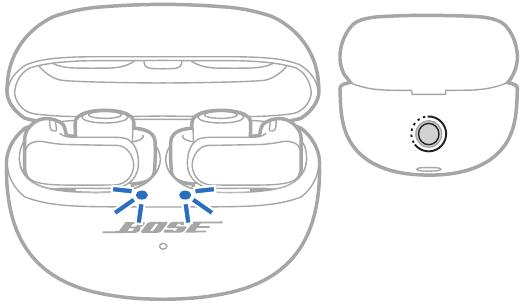

  Image 2 from bose-OpenAudio-manual.pdf:


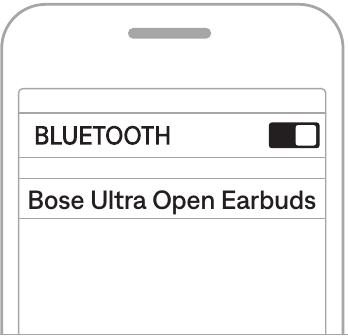


🤖 Composite text description:
----------------------------------------
NOTE: Make sure both earbuds are in the case and the case is open.

TIP: You can also make the earbuds ready to connect even if you don't have the case nearby. To do so, use the Bose Music app to set a shortcut to Switch Devices (see page 20). Then, press and hold the earbud button assigned to that shortcut until you hear "Ready to connect."

{ "type": "diagram", "description": "The diagram shows a pair of wireless earbuds in a charging case. The case is open, revealing the earbuds inside. There are blue lines pointing to the earbuds, indicating some feature or function. Below the earbuds, the text 'BOSE' is printed on the case. To the right, there is a smaller image of the back of the charging case, showing a button with a dotted circle around it, possibly indicating a reset or pairing button." }

BLUETOOTH CONNECTIONS

2. On your device, enable the Bluetooth feature.

NOTE: The Bluetooth feature is usually found 

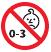

  Image 2 from bose-OpenAudio-manual.pdf:


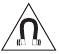


🤖 Composite text description:
----------------------------------------
• Use caution if using these headphones while performing any activity that requires your attention. Do not use the headphones when the inability to clearly hear surrounding sounds may present a danger to yourself or others, for example while riding a bicycle or walking in or near traffic, a construction site, railroad, etc.

• Do NOT submerge the product in water or expose the product to water for extended periods.

• Remove product immediately if you notice heat coming from the product.

IMPORTANT SAFETY INSTRUCTIONS

{ "type": "symbol", "description": "0-3" }

Contains small parts which may be a choking hazard. Not suitable for children under age 3.

{ "type": "symbol", "description": "The image is a triangular warning symbol containing a horseshoe magnet in the center. There is no text in the image." }

This product contains magnetic material. Consult your physician on whether this might affect your implantable 

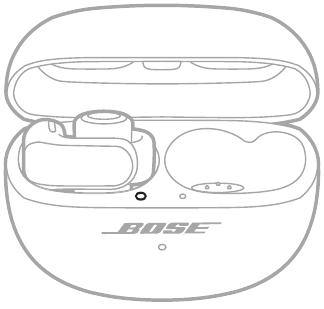

  Image 2 from bose-OpenAudio-manual.pdf:


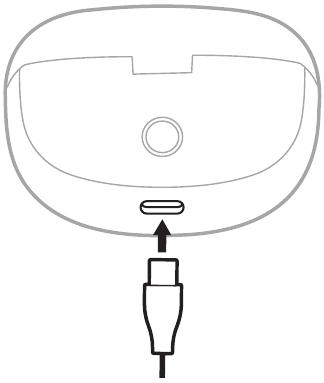


🤖 Composite text description:
----------------------------------------
NOTE: Before charging, make sure the earbuds are at room temperature, between 46° F (8° C) and 102° F (39° C).

2. Place the earbud in the case until it magnetically snaps into place.

The left earbud status light glows according to the charging status (see page 30).

{ "type": "diagram", "description": "The diagram shows an open charging case for wireless earbuds. Inside the case, there is one earbud placed in the left slot, while the right slot is empty. The case has a lid that is open, and there is a small circular button or indicator on the front of the case. The brand name 'BOSE' is printed on the front of the case below the button." }

3. Repeat steps 1 – 2 for the right earbud.

NOTE: The earbuds charge if the case is open or closed.

| ENG

BATTERY

CHARGE THE CHARGING CASE

CAUTION: Use this product only with an agency-approved LPS power supply that meets local regulatory requirements (e.g., UL, CSA, VDE, 

In [22]:
# Verification Block - Run this after the main pipeline to monitor progress and view results
# This block will wait for job completion and then display 5 random records with images

print("🔍 Starting verification process...")
print("⏳ This will monitor job progress and display results when complete")
print("-" * 60)

# Check if job_id is defined from the main pipeline execution above
try:
    # Try to access job_id variable
    if 'job_id' in locals() or 'job_id' in globals():
        print(f"📋 Using job_id from main pipeline: {job_id}")
        verify_customer_support_results(job_id)
    else:
        print("⚠️  job_id not found - running verification without job polling")
        verify_customer_support_results()
except NameError:
    print("⚠️  job_id variable not defined - running verification without job polling")
    verify_customer_support_results()
except Exception as e:
    print(f"⚠️  Error accessing job_id: {e} - running verification without job polling")
    verify_customer_support_results() 

## AI-Powered Visual Content Queries

Now we'll demonstrate querying your processed images using an intelligent agent system that understands visual content and AI-generated descriptions.

### OpenAI API Key Required

You'll need an OpenAI API key for the intelligent agent. Visit https://platform.openai.com/api-keys to generate one.

The demonstration shows intelligent image search and contextual responses about charts, diagrams, and visual content.

### AI Agent Configuration

The OpenAI API key from your `.env` file will be used to power the AI agent that understands your questions about images and generates contextual responses based on your extracted visual content.

🤖 Agentic Image-Enhanced RAG Query Demonstration Setup
✅ OpenAI API key configured for RAG demonstrations

🚀 Starting Agentic Image-Enhanced RAG Demonstration


INFO: GET https://2371b9a1d2ad40c590fd1e22652a8236.us-central1.gcp.cloud.es.io:443/ [status:200 duration:0.212s]


✅ Agentic Image RAG system components initialized successfully

🤖 Agentic RAG Query Demonstrations
The agent will intelligently decide whether to search for images, text, or all documents based on your query.

❓ What visual charts or graphs are shown in the documents?


INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO: POST https://2371b9a1d2ad40c590fd1e22652a8236.us-central1.gcp.cloud.es.io:443/image-pipeline/_search [status:200 duration:0.392s]


🖼️  Images (7 found):



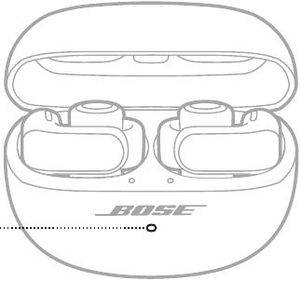
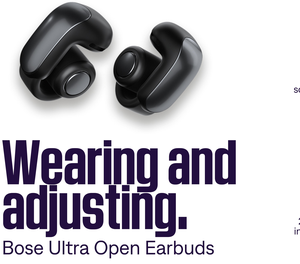
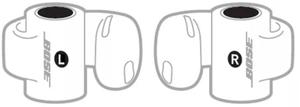
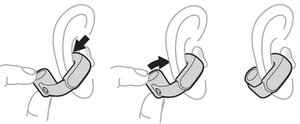
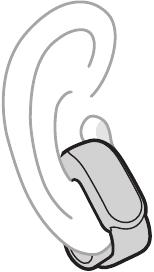
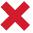
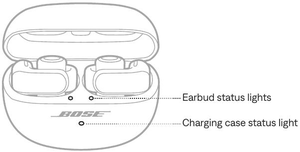

📝 Text content:
• Bluetooth status

Shows the Bluetooth connection status.

LIGHT ACTIVITY SYSTEM STATE Slowly blinks blue Ready to connect Quickly blinks blue Connecting Solid blue (5 seconds) Connected Blinks white 2 times Device list cleared

Battery, update, and error status

Shows the earbud battery, update, and error status.

LIGHT ACTIVITY SYSTEM STATE Glows solid white (10 minutes) Fully charged Slowly blinks amber (10 minutes) Charging Blinks white Determining earbud battery status Blinks white 2 times, slowly blinks blue, and turns off Reboot complete

EARBUD AND CHARGING C ASE STATUS

LIGHT ACTIVITY SYSTEM STATE Blinks white 3 times (repeated) Updating software Blinks amber (3 seconds) Restoring factory settings Blinks amber and white Error – contact Bose customer service

CHARGING CASE STATUS LIGHT

The charging case status light is located on the front of the charging case.

Charging case status light

{ "type": "diagram", "description": "The diagram shows a pair of wirele

INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO: POST https://2371b9a1d2ad40c590fd1e22652a8236.us-central1.gcp.cloud.es.io:443/image-pipeline/_search [status:200 duration:0.405s]
INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO: POST https://2371b9a1d2ad40c590fd1e22652a8236.us-central1.gcp.cloud.es.io:443/image-pipeline/_search [status:200 duration:0.419s]
INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



💬 Answer:
I searched for visual charts or graphs in the documents, but the results primarily included images and textual content related to Bose Ultra Open Earbuds and their Bluetooth status. Here are the findings:

1. **Document 1**: Contains an image of the Bose Ultra Open Earbuds with accompanying text about wearing and adjusting them. The image is visually descriptive but does not include a chart or graph.

2. **Document 2**: Features a section on Bluetooth status, detailing the connection states (e.g., blinking blue for ready to connect, solid blue for connected). This is more of a status indicator rather than a visual chart or graph.

3. **Documents 3, 4, and 5**: These documents focus on troubleshooting and do not provide any visual charts or graphs.

It appears that the documents retrieved do not contain traditional visual charts or graphs. If you are looking for specific types of visual data representations, please provide more details, and I can refine the search.

❓ What ar

INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO: POST https://2371b9a1d2ad40c590fd1e22652a8236.us-central1.gcp.cloud.es.io:443/image-pipeline/_search [status:200 duration:0.295s]


🖼️  Images (5 found):



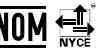
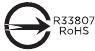
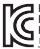
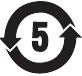
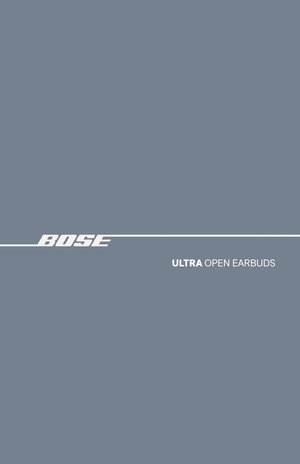

📝 Text content:
• Note 1: “b” indicates that the percentage content of the restricted substance does not exceed the percentage of reference value of presence.

Note 2: The “−” indicates that the restricted substance corresponds to the exemption.

REGULATORY AND LEGAL INFORMATION

Date of Manufacture: The eighth digit in the serial number indicates the year of manufacture; “4” is 2014 or 2024.

China Importer: Bose Electronics (Shanghai) Company Limited, Level 6, Tower D, No. 2337 Gudai Rd. Minhang District, Shanghai 201100 | EU Importer: Bose Products B.V., Gorslaan 60, 1441 RG Purmerend, The Netherlands | Mexico Importer: Bose de México S. de R.L. de C.V., Avenida Prado Sur #150, Piso 2, Interior 222 y 223, Colonia Lomas de Chapultepec V Sección, Miguel Hidalgo, Ciudad de México, C.P. 11000 Phone Number: +5255 (5202) 3545 | Taiwan Importer: Bose Limited Taiwan Branch (H.K.), 9F., No.10, Sec. 3, Minsheng E. Road, Zhongshan Dist. Taipei City 10480, Taiwan Phone Number: +886-2-2514 7676 

INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO: POST https://2371b9a1d2ad40c590fd1e22652a8236.us-central1.gcp.cloud.es.io:443/image-pipeline/_search [status:200 duration:0.331s]
INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



💬 Answer:
I used the **search_text_documents** tool because your question specifically asked for written specifications or technical details, which are typically found in textual content.

Here are the relevant details from the retrieved documents:

1. **Document: bose-OpenAudio-manual.pdf**
   - **Page 5**: Contains logos and compliance information, including references to RoHS (Restriction of Hazardous Substances) and other safety standards.
   - **Page 1**: Includes important safety instructions and a declaration of compliance with Directive 2014/53/EU, which outlines essential requirements for electronic devices.
   - **Pages 45, 49, and 51**: These pages contain troubleshooting information, which may include technical details related to the operation and maintenance of the product.

The documents primarily focus on safety instructions, compliance with regulations, and troubleshooting guidelines, which are essential components of technical specifications. If you need more specific

INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO: POST https://2371b9a1d2ad40c590fd1e22652a8236.us-central1.gcp.cloud.es.io:443/image-pipeline/_search [status:200 duration:0.307s]


📝 Text content:
• CONTENTS

IMMERSIVE AUDIO

Immersive audio settings ............................................................................................................................................. 21 Change the immersive audio setting ...................................................................................................................... 22 Change the mode ................................................................................................................................................ 22 Use your shortcut ................................................................................................................................................. 22 Immersive audio while on a call ................................................................................................................................ 22 Calibrate immersive audio ...........................................................................................................

INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO: POST https://2371b9a1d2ad40c590fd1e22652a8236.us-central1.gcp.cloud.es.io:443/image-pipeline/_search [status:200 duration:0.456s]
INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



💬 Answer:
I conducted a search for an overview of all content available in the documents, which led me to retrieve a selection of documents. Here’s a summary of the findings:

1. **Document 1**: 
   - **Filename**: bose-OpenAudio-manual.pdf
   - **Page**: 8
   - **Content**: Contains the table of contents, specifically mentioning sections related to immersive audio settings.

2. **Document 2**: 
   - **Filename**: bose-OpenAudio-manual.pdf
   - **Page**: 51
   - **Content**: Focuses on troubleshooting issues.

3. **Document 3**: 
   - **Filename**: bose-OpenAudio-manual.pdf
   - **Page**: 49
   - **Content**: Also addresses troubleshooting topics.

4. **Document 4**: 
   - **Filename**: bose-OpenAudio-manual.pdf
   - **Page**: 45
   - **Content**: Continues with troubleshooting information.

5. **Document 5**: 
   - **Filename**: bose-OpenAudio-manual.pdf
   - **Page**: 48
   - **Content**: Further details on troubleshooting.

### Overview:
The documents primarily consist of a manual 

INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO: POST https://2371b9a1d2ad40c590fd1e22652a8236.us-central1.gcp.cloud.es.io:443/image-pipeline/_search [status:200 duration:0.384s]


🖼️  Images (6 found):



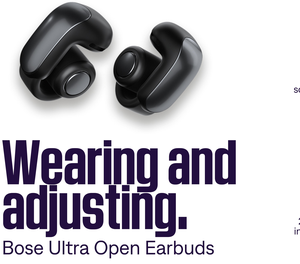
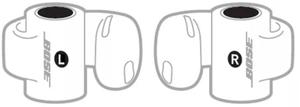
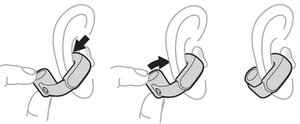
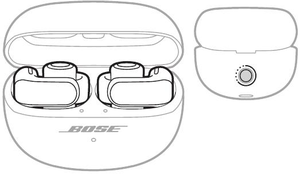
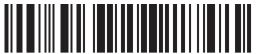
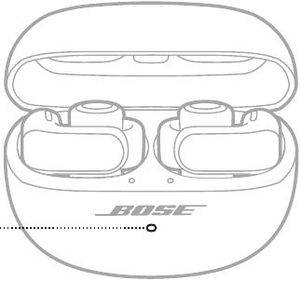

📝 Text content:
• {"type":"image","description":"The image shows a pair of black earbuds, specifically the Bose Ultra Open Earbuds. Below the earbuds, there is text in large, bold font that reads 'Wearing and adjusting.' In smaller font below, it says 'Bose Ultra Open Earbuds.' The background is white, and the text is in a dark color, likely black or dark blue."}

{"type":"diagram","description":"The image is a diagram showing two earbud-like shapes, representing left and right earbuds. The left earbud has the text 'BOSE' written vertically along its side and a black circle with the letter 'L' inside it. The right earbud also has the text 'BOSE' written vertically along its side and a black circle with the letter 'R' inside it."}

1. Hold the barrel-shaped part of the earbuds so the button is on top and the R (right) or L (left) marking is facing you.

{ "type": "diagram", "description": "The diagram shows a step-by-step process of inserting an earbud into an ear. The first image on th

INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO: POST https://2371b9a1d2ad40c590fd1e22652a8236.us-central1.gcp.cloud.es.io:443/image-pipeline/_search [status:200 duration:0.388s]
INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



💬 Answer:
I used the **search_all_documents** tool because your query requested both diagrams (visual content) and technical documentation (textual content) related to product architecture. This approach allows for a comprehensive search across both types of documents.

### Search Results:

1. **Diagrams:**
   - The search did not return specific diagrams related to product architecture. However, there is an image in the document titled **bose-OpenAudio-instructions.pdf** that features the Bose Ultra Open Earbuds, which may not directly relate to product architecture but could provide some visual context about the product.

2. **Technical Documentation:**
   - The documents retrieved are primarily from the **bose-OpenAudio-manual.pdf**, which includes several pages (45, 48, 49, 51) that mention troubleshooting. Unfortunately, these pages do not seem to provide detailed information about product architecture.

### Conclusion:
While I found some visual content and technical documentatio

In [23]:
import os
import json
import base64
from IPython.display import Image, display

# LangChain imports for RAG functionality
from langchain_elasticsearch import ElasticsearchStore
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.tools import tool
from langchain.agents import create_openai_functions_agent, AgentExecutor

# Environment variables are expected to be available in the global scope
# (defined earlier in the notebook/script)

print("🤖 Agentic Image-Enhanced RAG Query Demonstration Setup")
print("=" * 60)

if not OPENAI_API_KEY or OPENAI_API_KEY.startswith("your-"):
    print("⚠️ OpenAI API key not configured.")
    print("💡 Please set OPENAI_API_KEY in your .env file with your actual OpenAI API key.")
    print("📝 You can get one at: https://platform.openai.com/api-keys")
else:
    print("✅ OpenAI API key configured for RAG demonstrations")

def setup_image_rag_system():
    """Set up the RAG system with Elasticsearch and OpenAI for image processing."""
    try:
        # Initialize OpenAI embeddings
        embeddings = OpenAIEmbeddings(
            model="text-embedding-3-small",
            openai_api_key=OPENAI_API_KEY
        )
        
        # Initialize Elasticsearch vector store for image-pipeline index
        vector_store = ElasticsearchStore(
            es_url=ELASTICSEARCH_HOST,
            index_name="image-pipeline",
            embedding=embeddings,
            es_api_key=ELASTICSEARCH_API_KEY
        )
        
        # Initialize ChatOpenAI
        llm = ChatOpenAI(
            model="gpt-4o-mini",
            openai_api_key=OPENAI_API_KEY,
            temperature=0
        )
        
        print("✅ Agentic Image RAG system components initialized successfully")
        return {
            'vector_store': vector_store,
            'embeddings': embeddings,
            'llm': llm
        }
        
    except Exception as e:
        print(f"❌ Error setting up Agentic Image RAG system: {e}")
        print("💡 Make sure your Elasticsearch and OpenAI credentials are correct")
        return None

def display_image_from_base64(image_base64, record_id):
    """Display a base64 encoded image."""
    try:
        image_data = base64.b64decode(image_base64)
        print(f"🖼️  Image from record {record_id}:")
        display(Image(data=image_data))
        return True
    except Exception as e:
        print(f"❌ Error displaying image from record {record_id}: {e}")
        return False

def create_agentic_rag_tools(rag_components):
    """Create tools for the agentic RAG system."""
    
    @tool
    def search_image_documents(question: str, k: int = 5) -> str:
        """
        Search for CompositeElement documents containing images in orig_elements.
        Use this when the user asks about visual content, images, charts, diagrams, graphs, 
        illustrations, pictures, or any visual elements.
        
        Args:
            question: The search query about visual content
            k: Number of documents to retrieve (default 5)
            
        Returns:
            String containing formatted results with image information
        """
        from elasticsearch import Elasticsearch
        
        es = Elasticsearch(
            ELASTICSEARCH_HOST,
            api_key=ELASTICSEARCH_API_KEY,
            request_timeout=60,
            max_retries=3,
            retry_on_timeout=True
        )
        
        try:
            # Get embeddings for the question
            embeddings = rag_components['embeddings']
            question_embedding = embeddings.embed_query(question)
            
            # Search for CompositeElement documents with orig_elements containing images
            search_body = {
                "size": k,
                "_source": True,
                "query": {
                    "bool": {
                        "must": [
                            {
                                "term": {
                                    "type": "CompositeElement"
                                }
                            },
                            {
                                "exists": {
                                    "field": "metadata.orig_elements"
                                }
                            },
                            {
                                "script_score": {
                                    "query": {"match_all": {}},
                                    "script": {
                                        "source": "cosineSimilarity(params.query_vector, 'embeddings') + 1.0",
                                        "params": {
                                            "query_vector": question_embedding
                                        }
                                    }
                                }
                            }
                        ]
                    }
                }
            }
            
            response = es.search(index="image-pipeline", body=search_body)
            
            # Format results for CompositeElement documents with images
            if response['hits']['hits']:
                results = []
                for i, hit in enumerate(response['hits']['hits'], 1):
                    source = hit['_source']
                    metadata = source.get('metadata', {})
                    orig_elements = metadata.get('orig_elements', [])
                    
                    # Count images in orig_elements
                    image_count = sum(1 for elem in orig_elements if elem.get('type') == 'Image')
                    
                    if image_count > 0:  # Only include documents that actually contain images
                        result = f"Composite Document {i} (contains {image_count} image(s)):\n"
                        result += f"- Filename: {metadata.get('filename', 'N/A')}\n"
                        result += f"- Page: {metadata.get('page_number', 'N/A')}\n"
                        result += f"- Total orig_elements: {len(orig_elements)}\n"
                        result += f"- Composite Description: {source.get('text', 'No description available')}\n"
                        
                        results.append(result)
                
                if results:
                    return f"Found {len(results)} composite documents with images:\n\n" + "\n---\n".join(results)
                else:
                    return f"No composite documents with images found for query: '{question}'"
            else:
                return f"No CompositeElement documents found for query: '{question}'"
            
        except Exception as e:
            return f"Error searching image documents: {e}"
    
    @tool
    def search_text_documents(question: str, k: int = 5) -> str:
        """
        Search for text-based documents (any type except 'Image'). 
        Use this when the user asks about textual content, written information, 
        specifications, instructions, or general document content.
        
        Args:
            question: The search query about textual content
            k: Number of documents to retrieve (default 5)
            
        Returns:
            String containing formatted results with text information
        """
        from elasticsearch import Elasticsearch
        
        es = Elasticsearch(
            ELASTICSEARCH_HOST,
            api_key=ELASTICSEARCH_API_KEY,
            request_timeout=60,
            max_retries=3,
            retry_on_timeout=True
        )
        
        try:
            # Get embeddings for the question
            embeddings = rag_components['embeddings']
            question_embedding = embeddings.embed_query(question)
            
            # Search with type exclusion filter and vector similarity
            search_body = {
                "size": k,
                "_source": True,
                "query": {
                    "bool": {
                        "must": [
                            {
                                "script_score": {
                                    "query": {"match_all": {}},
                                    "script": {
                                        "source": "cosineSimilarity(params.query_vector, 'embeddings') + 1.0",
                                        "params": {
                                            "query_vector": question_embedding
                                        }
                                    }
                                }
                            }
                        ],
                        "must_not": [
                            {
                                "term": {
                                    "type": "Image"
                                }
                            }
                        ]
                    }
                }
            }
            
            response = es.search(index="image-pipeline", body=search_body)
            
            # Format results
            results = []
            for i, hit in enumerate(response['hits']['hits'], 1):
                source = hit['_source']
                metadata = source.get('metadata', {})
                
                result = f"Text Document {i}:\n"
                result += f"- Filename: {metadata.get('filename', 'N/A')}\n"
                result += f"- Page: {metadata.get('page_number', 'N/A')}\n"
                result += f"- Type: {source.get('type', 'Unknown')}\n"
                result += f"- Content: {source.get('text', 'No content available')[:300]}...\n"
                
                results.append(result)
            
            return f"Found {len(results)} text documents:\n\n" + "\n---\n".join(results)
            
        except Exception as e:
            return f"Error searching text documents: {e}"
    
    @tool
    def search_all_documents(question: str, k: int = 5) -> str:
        """
        Search across all document types without filtering. 
        Use this when the user's query is general or when you need comprehensive results 
        from both image and text documents.
        
        Args:
            question: The general search query
            k: Number of documents to retrieve (default 5)
            
        Returns:
            String containing formatted results from all document types
        """
        from elasticsearch import Elasticsearch
        
        es = Elasticsearch(
            ELASTICSEARCH_HOST,
            api_key=ELASTICSEARCH_API_KEY,
            request_timeout=60,
            max_retries=3,
            retry_on_timeout=True
        )
        
        try:
            # Get embeddings for the question
            embeddings = rag_components['embeddings']
            question_embedding = embeddings.embed_query(question)
            
            # Search all documents with vector similarity
            search_body = {
                "size": k,
                "_source": True,
                "query": {
                    "script_score": {
                        "query": {"match_all": {}},
                        "script": {
                            "source": "cosineSimilarity(params.query_vector, 'embeddings') + 1.0",
                            "params": {
                                "query_vector": question_embedding
                            }
                        }
                    }
                }
            }
            
            response = es.search(index="image-pipeline", body=search_body)
            
            # Format results
            results = []
            for i, hit in enumerate(response['hits']['hits'], 1):
                source = hit['_source']
                metadata = source.get('metadata', {})
                doc_type = source.get('type', 'Unknown')
                
                result = f"Document {i} (Type: {doc_type}):\n"
                result += f"- Filename: {metadata.get('filename', 'N/A')}\n"
                result += f"- Page: {metadata.get('page_number', 'N/A')}\n"
                
                if doc_type == "Image":
                    result += f"- Visual Content: {'Available' if metadata.get('image_base64') else 'Not available'}\n"
                    result += f"- Description: {source.get('text', 'No description available')}\n"
                else:
                    result += f"- Content: {source.get('text', 'No content available')[:300]}...\n"
                
                results.append(result)
            
            return f"Found {len(results)} documents of various types:\n\n" + "\n---\n".join(results)
            
        except Exception as e:
            return f"Error searching all documents: {e}"
    
    return [search_image_documents, search_text_documents, search_all_documents]

def display_document_content(documents, question_num):
    """Display the actual document content (images and text) used for answering."""
    from PIL import Image as PILImage
    import io
    from IPython.display import HTML
    
    images = []
    texts = []
    

    # Collect all images and texts from documents
    for doc in documents:
        # Handle the case where doc might be a string instead of a dict
        if isinstance(doc, str):
            print(f"⚠️ Warning: Expected document dict but got string: {doc[:100]}...")
            continue
            
        if not isinstance(doc, dict) or '_source' not in doc:
            print(f"⚠️ Warning: Document missing _source field: {type(doc)} - {doc}")
            continue
            
        source = doc['_source']
        metadata = source.get('metadata', {})
        doc_type = source.get('type', 'Unknown')
        
        # Handle CompositeElement documents with orig_elements
        if doc_type == "CompositeElement":
            orig_elements = metadata.get('orig_elements', [])
            
            # Handle the case where orig_elements is stored as a JSON string or compressed data
            if isinstance(orig_elements, str):
                try:
                    import json
                    # First try to parse as plain JSON
                    orig_elements = json.loads(orig_elements)
                except json.JSONDecodeError:
                    try:
                        # If that fails, try to decompress first (looks like base64 + compression)
                        import base64
                        import zlib
                        compressed_data = base64.b64decode(orig_elements)
                        decompressed_data = zlib.decompress(compressed_data)
                        orig_elements = json.loads(decompressed_data.decode('utf-8'))
                    except Exception:
                        # If all else fails, skip this document's images
                        orig_elements = []
            
            # Ensure orig_elements is a list
            if not isinstance(orig_elements, list):
                print(f"⚠️ Warning: orig_elements is not a list, it's {type(orig_elements)}")
                orig_elements = []
            
            # Look for images in orig_elements
            for element in orig_elements:
                # Ensure element is a dictionary before calling .get()
                if not isinstance(element, dict):
                    print(f"⚠️ Warning: element is not a dict, it's {type(element)}: {element}")
                    continue
                    
                if element.get('type') == 'Image' and element.get('metadata', {}).get('image_base64'):
                    try:
                        image_data = base64.b64decode(element['metadata']['image_base64'])
                        filename = element.get('metadata', {}).get('filename', 'document')
                        images.append((image_data, filename))
                    except Exception as e:
                        print(f"❌ Error processing image from orig_elements: {e}")
            
            # Use composite text content
            text_content = source.get('text', '')
            if text_content:
                texts.append(text_content)
        
        # Handle legacy Image documents (if any still exist)
        elif doc_type == "Image" and metadata.get('image_base64'):
            try:
                image_data = base64.b64decode(metadata['image_base64'])
                filename = metadata.get('filename', 'document')
                images.append((image_data, filename))
            except Exception as e:
                print(f"❌ Error processing direct image: {e}")
            
            # Use image text content
            text_content = source.get('text', '')
            if text_content:
                texts.append(text_content)
        
        # Handle other document types
        else:
            text_content = source.get('text', '')
            if text_content:
                texts.append(text_content)
    
    # Display images in a grid if multiple, single if one
    if images:
        if len(images) == 1:
            print(f"🖼️  Image from {images[0][1]}:")
            display(Image(data=images[0][0]))
        else:
            print(f"🖼️  Images ({len(images)} found):")
            # Create HTML grid for multiple images
            html_content = '<div style="display: flex; flex-wrap: wrap; gap: 10px; margin: 10px 0;">'
            for i, (image_data, filename) in enumerate(images):
                try:
                    # Convert to PIL Image to resize
                    pil_img = PILImage.open(io.BytesIO(image_data))
                    # Resize to max 300px width while maintaining aspect ratio
                    if pil_img.width > 300:
                        ratio = 300 / pil_img.width
                        new_height = int(pil_img.height * ratio)
                        pil_img = pil_img.resize((300, new_height), PILImage.Resampling.LANCZOS)
                    
                    # Convert back to base64
                    buffer = io.BytesIO()
                    pil_img.save(buffer, format='PNG')
                    img_base64 = base64.b64encode(buffer.getvalue()).decode()
                    
                    html_content += f'''
                    <div style="text-align: center; margin: 5px;">
                        <img src="data:image/png;base64,{img_base64}" style="max-width: 300px; border: 1px solid #ddd; border-radius: 4px;">
                        <div style="font-size: 12px; color: #666; margin-top: 5px;">{filename}</div>
                    </div>
                    '''
                except Exception as e:
                    html_content += f'<div style="color: red;">Error loading image from {filename}</div>'
            
            html_content += '</div>'
            display(HTML(html_content))
    
    # Display text content
    if texts:
        print(f"📝 Text content:")
        for text in texts:
            print(f"• {text}")
            print()

def get_documents_for_query(question, rag_components, k=3):
    """Get the actual documents that would be used to answer a query."""
    from elasticsearch import Elasticsearch
    
    es = Elasticsearch(
        ELASTICSEARCH_HOST,
        api_key=ELASTICSEARCH_API_KEY,
        request_timeout=60,
        max_retries=3,
        retry_on_timeout=True
    )
    
    try:
        # Get embeddings for the question
        embeddings = rag_components['embeddings']
        question_embedding = embeddings.embed_query(question)
        
        # Search all documents with vector similarity
        search_body = {
            "size": k,
            "_source": True,
            "query": {
                "script_score": {
                    "query": {"match_all": {}},
                    "script": {
                        "source": "cosineSimilarity(params.query_vector, 'embeddings') + 1.0",
                        "params": {
                            "query_vector": question_embedding
                        }
                    }
                }
            }
        }
        
        response = es.search(index="image-pipeline", body=search_body)
        return response['hits']['hits']
        
    except Exception as e:
        print(f"❌ Error retrieving documents: {e}")
        return []

def demonstrate_agentic_rag_queries(rag_components):
    """Demonstrate agentic RAG queries that intelligently choose retrieval strategy."""
    llm = rag_components['llm']
    
    print("\n🤖 Agentic RAG Query Demonstrations")
    print("=" * 50)
    print("The agent will intelligently decide whether to search for images, text, or all documents based on your query.")
    
    # Create tools
    tools = create_agentic_rag_tools(rag_components)
    
    # Create agent prompt
    agent_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are an intelligent document search agent. You have access to three tools:

1. search_image_documents: Use when users ask about visual content (images, charts, diagrams, graphs, illustrations, pictures, visual elements)
2. search_text_documents: Use when users ask about textual content (written information, specifications, instructions, general text)
3. search_all_documents: Use when the query is general or needs comprehensive results from both types

Analyze the user's question and choose the most appropriate tool(s). After getting search results, provide a comprehensive answer based on the retrieved information.

Always explain which search strategy you chose and why."""),
        ("human", "{input}"),
        ("placeholder", "{agent_scratchpad}")
    ])
    
    # Create agent
    agent = create_openai_functions_agent(llm, tools, agent_prompt)
    agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=False, max_iterations=3)
    
    # Test queries that require different strategies
    test_queries = [
        {
            "question": "What visual charts or graphs are shown in the documents?",
            "description": "Visual content query - should use image search"
        },
        {
            "question": "What are the written specifications or technical details mentioned?",
            "description": "Text content query - should use text search"
        },
        {
            "question": "Give me an overview of all the content available in the documents",
            "description": "General query - should use comprehensive search"
        },
        {
            "question": "Are there any diagrams showing the product architecture, and what do the technical docs say about it?",
            "description": "Mixed query - might use multiple search strategies"
        }
    ]
    
    for i, query in enumerate(test_queries, 1):
        # Clean question header
        print(f"\n{'='*80}")
        print(f"❓ {query['question']}")
        print(f"{'='*80}")
        
        try:
            # Get the documents that will be used for this query
            documents = get_documents_for_query(query['question'], rag_components, k=3)
            
            # Display the source content used for the answer
            if documents:
                display_document_content(documents, i)
            else:
                print("📄 No relevant documents found")
            
            # Get the answer (silently, without showing agent steps)
            result = agent_executor.invoke({"input": query['question']})
            
            print(f"\n💬 Answer:")
            print(f"{result['output']}")
                
        except Exception as e:
            print(f"❌ Error: {e}")

    print(f"\n{'='*80}")
    print("✅ Agentic RAG demonstration completed")
    print("💡 The agent intelligently chose different search strategies based on query type")
    print(f"{'='*80}")

def run_agentic_rag_demonstration():
    """Run the agentic RAG demonstration."""
    print("\n🚀 Starting Agentic Image-Enhanced RAG Demonstration")
    print("=" * 70)
    
    rag_components = setup_image_rag_system()
    
    if rag_components:
        demonstrate_agentic_rag_queries(rag_components)
    else:
        print("❌ Agentic RAG demonstration skipped due to configuration issues")

# Run the demonstration
run_agentic_rag_demonstration()

## Interactive Q&A Session

Now that your image-enhanced RAG system is set up and populated with data, you can ask your own questions! The system intelligently searches through both textual content and AI-generated image descriptions to provide comprehensive answers.

### How to Use

1. **Modify the question**: Edit the `user_question` variable below with your own question
2. **Run the cell**: Execute to get an AI-powered answer based on your documents
3. **Review sources**: See which specific documents and pages were used to generate the answer

### Example Questions You Can Ask

- "What visual diagrams or charts are shown in the documents?"
- "What are the technical specifications mentioned?"
- "Show me information about product features and capabilities"
- "What safety instructions or warnings are provided?"
- "Are there any troubleshooting guides or error codes?"

The system will automatically determine whether to search image descriptions, text content, or both based on your question.

In [24]:
# LangChain imports for agent creation
from langchain_core.prompts import ChatPromptTemplate
from langchain.agents import create_openai_functions_agent, AgentExecutor

# Interactive Q&A - Modify the question below to ask your own questions
user_question = "What are the key features of the products shown in the documents?"

print(f"🤔 Question: {user_question}")
print("=" * 60)

# Set up the RAG system and get an answer
rag_components = setup_image_rag_system()

if rag_components:
    try:
        # Create agentic RAG tools and agent
        tools = create_agentic_rag_tools(rag_components)
        llm = rag_components['llm']
        
        # Create agent prompt
        agent_prompt = ChatPromptTemplate.from_messages([
            ("system", """You are an intelligent document search agent. You have access to three tools:

1. search_image_documents: Use when users ask about visual content (images, charts, diagrams, graphs, illustrations, pictures, visual elements)
2. search_text_documents: Use when users ask about textual content (written information, specifications, instructions, general text)
3. search_all_documents: Use when the query is general or needs comprehensive results from both types

Analyze the user's question and choose the most appropriate tool(s). After getting search results, provide a comprehensive answer based on the retrieved information.

Always explain which search strategy you chose and why."""),
            ("human", "{input}"),
            ("placeholder", "{agent_scratchpad}")
        ])
        
        # Create and run agent
        agent = create_openai_functions_agent(llm, tools, agent_prompt)
        agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=False, max_iterations=3)
        
        # Get the answer using the agentic RAG system
        result = agent_executor.invoke({"input": user_question})
        
        print(f"💡 Answer: {result['output']}")
        
    except Exception as e:
        print(f"❌ Error getting answer: {e}")
else:
    print("❌ RAG system not available - please ensure the pipeline has completed successfully") 

🤔 Question: What are the key features of the products shown in the documents?


INFO: GET https://2371b9a1d2ad40c590fd1e22652a8236.us-central1.gcp.cloud.es.io:443/ [status:200 duration:0.248s]


✅ Agentic Image RAG system components initialized successfully


INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO: POST https://2371b9a1d2ad40c590fd1e22652a8236.us-central1.gcp.cloud.es.io:443/image-pipeline/_search [status:200 duration:0.437s]
INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


💡 Answer: I retrieved several documents related to the products, specifically focusing on the Bose Open Audio earbuds. Here are the key features and relevant information extracted from the documents:

1. **Product Overview**:
   - The Bose Open Audio earbuds are designed for a seamless audio experience, emphasizing comfort and connectivity.

2. **Connectivity**:
   - The earbuds can connect to various Bose products, including smart speakers and soundbars, enhancing the audio experience across devices.

3. **Regulatory Information**:
   - The documents include important regulatory and legal information, such as compliance with substance restrictions and trademark notices.

4. **User Instructions**:
   - There are instructions on how to store the earbuds and clean both the earbuds and the charging case, which are essential for maintaining product longevity.

5. **Licensing and Terms**:
   - The terms of use and license disclosures for third-party software included with the product are al

## What You've Learned

**AI-Powered Visual Intelligence**: You've learned how to extract images from complex PDF documents with high-resolution processing, generate searchable AI descriptions for visual content, and create vector embeddings for semantic image similarity search across your document collection.

**Unstructured API Capabilities**: You've experienced intelligent image detection and extraction from PDFs, AI-powered image description generation using advanced vision models, optimized storage and indexing for visual content search, and seamless integration with your existing document workflows.

**Visual RAG System Architecture**: You've built a specialized image processing pipeline for scalability and reliability, AI-generated descriptions that make images searchable through natural language, intelligent agent systems that understand visual content queries, and vector-based similarity search for finding related visual content.

### Ready to Scale?

Deploy visual content discovery systems for technical documentation, build intelligent image search tools for product catalogs, or create AI-powered visual asset management systems. Add more document sources using additional S3 buckets, implement real-time visual content processing, or scale up for production document volumes with automated visual content categorization.

### Try Unstructured Today

Ready to build your own AI-powered image processing system? [Sign up for a free trial](https://unstructured.io/?modal=try-for-free) and start transforming your visual content into intelligent, searchable knowledge.

**Need help getting started?** Contact our team to schedule a demo and see how Unstructured can solve your specific visual content challenges.